## 1. Покрытие генома

bwa index MG1655-K12.first10K.fasta

bwa mem MG1655-K12.first10K.fasta test_1.fastq > test_1.sam

samtools flagstat test_1.sam

samtools view -Sb test.sam > test.bam

samtools sort test.bam > test_sorted.bam

samtools depth test_sorted.bam > test_coverage.txt





Среднее покрытие: 508
Доля покрытой области генома: 100.0%


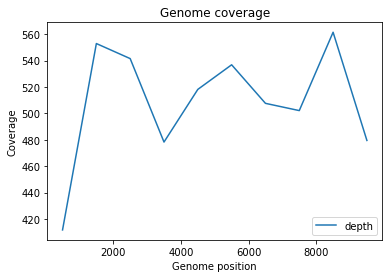

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plotGenomeCoverage(fileName, avgWindow):
    df = pd.read_csv(fileName, sep="\t", usecols=[1,2], header=None)
    df = df.rename(columns = {1: "genome_position", 2: "depth"})
    df_averaged = df.groupby(np.arange(len(df))//avgWindow).mean()

    df_averaged.plot(x="genome_position", y="depth")
    plt.ylabel("Coverage")
    plt.xlabel("Genome position")
    plt.title("Genome coverage")

    print(f"Среднее покрытие: {int(df.depth.mean())}")
    print(f"Доля покрытой области генома: {df.depth[df.depth>0].count()/len(df)*100}%")

plotGenomeCoverage("data/HW2/test/test_coverage.txt", 1000)

## 2. Распределение расстояния вставки

 samtools stats test_sorted.bam | grep ^IS | cut -f 2- > insertsizes.txt

Text(0.5, 1.0, 'Insert sizes distribution')

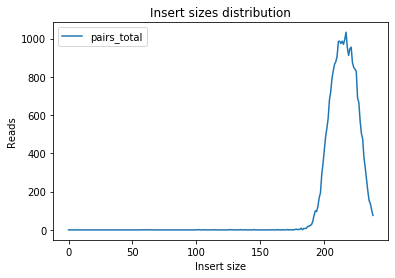

In [46]:
df = pd.read_csv("data/HW2/test/insertsizes.txt", sep="\t", usecols=[0,1], header=None)
df = df.rename(columns = {0: "insert_size", 1: "pairs_total"})
df.plot(x="insert_size", y="pairs_total")
plt.ylabel("Reads")
plt.xlabel("Insert size")
plt.title("Insert sizes distribution")



In [78]:
mean = (df.insert_size*df.pairs_total).sum()/df.pairs_total.sum()
print(f"Среднее расстояние вставки: {mean}")
std = np.sqrt(np.cov(df.insert_size, aweights=df.pairs_total))
print(f"Среднеквадратичное отклонение: {std}")

print(f"95% доверительный интервал: ({mean - 2*std}, {mean + 2*std})")


Среднее расстояние вставки: 215.07366838487974
Среднеквадратичное отклонение: 10.504082908706701
95% доверительный интервал: (194.06550256746632, 236.08183420229315)


## 3. Частоты различных замен

In [39]:
import pysam
from Bio import SeqIO
from collections import Counter

subsMatrix = np.zeros(shape =(4,4))

symMap = {"A":0,"C":1,"G":2,"T":3,"a":0,"c":1,"g":2,"t":3}

samfile = pysam.AlignmentFile("data/HW2/test/test_sorted.bam", "rb" )

seqIo = list(SeqIO.parse("data/HW2/test/MG1655-K12.first10K.fasta", "fasta"))

for pileupcolumn in samfile.pileup():
    ref_pos = pileupcolumn.reference_pos
    ref_base = seqIo[pileupcolumn.reference_id].seq[ref_pos]

    counts = Counter(pileupcolumn.get_query_sequences())
    for key in counts.keys():
        #if(key!=ref_base and str.upper(key)!=ref_base):
        subsMatrix[symMap[key], symMap[ref_base]] += counts[key]

matrix = pd.DataFrame(subsMatrix, dtype=int)
matrix.index = ["A","C","G","T"]
matrix.columns = ["A","C","G","T"]
matrix

,A,C,G,T
A,1253745,0,0,0
C,12,1251591,11,0
G,8,2,1352566,11
T,1,0,27,1165177


## 2.1. Статистика ридов IonTorrent


bwa index ion_reference.fasta  
bwa mem ion_reference.fasta B22-730.fastq > ion.sam  
** 489459 + 0 mapped (98.41% : N/A) **  
samtools view -Sb ion.sam > ion.bam  

samtools stats ion_sorted.bam > ion_stats.txt  

samtools stats ion_sorted.bam | grep ^ID | cut -f 2- > ion_indels.txt

samtools index ion_sorted.bam

Среднее покрытие: 33
Доля покрытой области генома: 99.98796450039767%


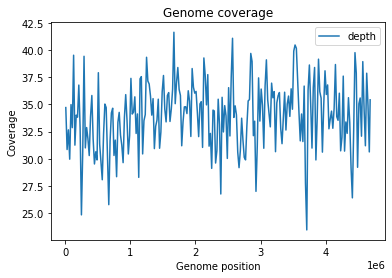

In [49]:
plotGenomeCoverage("data/HW2/test/ion_coverage.txt", 20000)

Средний процент ошибок в ридах (*поле `error rate` в результатах `samtools stats`*): $6.695761e-03$

Text(0.5, 1.0, 'Indels distribution')

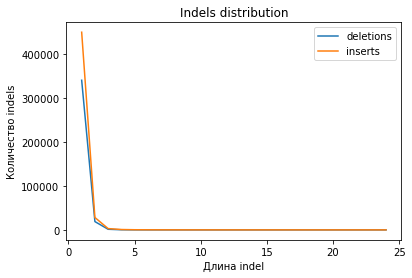

In [56]:
df = pd.read_csv("data/HW2/test/ion_indels.txt", sep="\t", usecols=[0,1,2], header=None)
df = df.rename(columns = {0: "length", 1: "inserts", 2:"deletions"})
df.plot(x="length", y=["deletions","inserts"])

plt.ylabel("Количество indels")
plt.xlabel("Длина indel")
plt.title("Indels distribution")

In [88]:
import re

homopolymers = [] 

for nucl in ['A','C','T','G']:
    pattern = re.compile(nucl + "{10,}")
    for record in SeqIO.parse("data/HW2/test/ion_reference.fasta", "fasta"):
        for match in pattern.finditer(str(record.seq).upper()):
            homopolymers.append((match.start(), match.end()))




In [82]:
subsMatrix = np.zeros(shape =(5,5))

symMap = {"A":0,"C":1,"G":2,"T":3,"a":0,"c":1,"g":2,"t":3,'_':4}

samfile = pysam.AlignmentFile("data/HW2/test/ion_sorted.bam", "rb" )

seqIo = list(SeqIO.parse("data/HW2/test/ion_reference.fasta", "fasta"))

for pileupcolumn in samfile.pileup():
    ref_pos = pileupcolumn.reference_pos
    ref_base = seqIo[pileupcolumn.reference_id].seq[ref_pos]
    pileupcolumn
    counts = Counter(pileupcolumn.get_query_sequences(add_indels = True))
    for key in counts.keys():
        #if(key!=ref_base and str.upper(key)!=ref_base):
        if("AA" in key):
            print(key, counts[key])
            print(seqIo[pileupcolumn.reference_id].seq[ref_pos])
            break 
        if("-" in key):
            subsMatrix[symMap["_"], symMap[key[0]]] += counts[key]
        elif("+" in key):
            subsMatrix[symMap[key[-1]], symMap["_"]] += counts[key]
        elif("*" not in key):
            subsMatrix[symMap[key], symMap[ref_base]] += counts[key]

matrix = pd.DataFrame(subsMatrix, dtype=int)
matrix.index = ["A","C","G","T", '_']
matrix.columns = ["A","C","G","T", '_']

matrix

T+2AA 1
T
A+3AAG 2
A
C+2AA 1
C
T+2AA 1
T
G+2AA 1
G
C+2AA 1
C
C+3AAA 1
C
G+2AA 1
G
C+9AAAAAAAAA 1
C
G+7AAAAAAA 1
G
G+2AA 1
G
C+2AA 1
C
T+10AAAAAAAAAA 1
T
T+2AA 1
T
C+4AAAA 1
C
A+3AAT 1
A
C+4AAAA 1
C
G+2AA 1
G
T+2AA 1
T
T+3TAA 1
T
T+4AAAA 1
T
T+2AA 1
T
A+4AAAC 1
A
T+2AA 2
T
C+2AA 1
C
G+4GAAA 1
G
C+2AA 1
C
C+9AAAAAAAAA 1
C
T+7AAAAAAA 1
T
C+2AA 1
C
T+11AAAAAAAAAAA 1
T
C+2AA 1
C
T+6AAAAAA 1
T
T+3TAA 1
T
T+2AA 2
T
G+2AA 2
G
G+3GAA 1
G
T+2AA 1
T
A+3AAG 1
A
C+2AA 1
C
G+2AA 1
G
C+2AA 1
C
G+4GGAA 1
G
A+3AAT 1
A
A+6AGAATT 1
A
G+2AA 1
G
G+2AA 1
G
G+9AAAAAAAAA 1
G
T+2AA 6
T
C+3AAA 1
C
G+2AA 1
G
T+3AAA 2
T
G+2AA 1
G
T+3AAA 1
T
C+3CAA 1
C
C+7AAAAAAA 1
C
T+3TAA 1
T
T+2AA 1
T
T+3TAA 1
T
G+3AAA 1
G
C+16AAAAAAAAAAAAAAAA 1
C
G+2AA 1
G
G+5AATTC 1
G
T+2AA 1
T
G+3AAA 1
G
C+2AA 1
C
C+4AAAA 1
C
C+2AA 2
C
C+2AA 1
C
A+3AAC 1
A
A+5AAGGG 1
A
G+5GAAAA 1
G
C+3AAA 1
C
C+5AAAAA 1
C
T+2AA 1
T
G+2AA 1
G
G+3AAA 1
G
T+2AA 2
T
T+2AA 1
T
G+4AAAA 1
G
G+2AA 1
G
G+7AAAAAAA 1
G
T+3AAA 1
T
T+3AAA 1
T
T+5AAAAA 1
T
G+3AAA 2
G
A+3A

KeyboardInterrupt: 